# CLUSTERING ASSIGNMENT

# Problem Statement

HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities. It runs a lot of operational projects from time to time along with advocacy drives to raise awareness as well as for funding purposes.

 

After the recent funding programmes, they have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. The significant issues that come while making this decision are mostly related to choosing the countries that are in the direst need of aid. 



And this is where you come in as a data analyst. Your job is to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then you need to suggest the countries which the CEO needs to focus on the most. 

##### Submitted By: Neha Shukla

In [677]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

#importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# Data Loading

In [678]:
#reading the dataset
countryData=pd.read_csv("Country-data.csv")
countryData.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


# Data Inspection

In [679]:
# basics of the countryData
countryData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [680]:
countryData.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [681]:
countryData.shape

(167, 10)

# Data Cleaning

In [682]:
#Missing values
round(100*countryData.isnull().sum()/len(countryData),2)

country       0.0
child_mort    0.0
exports       0.0
health        0.0
imports       0.0
income        0.0
inflation     0.0
life_expec    0.0
total_fer     0.0
gdpp          0.0
dtype: float64

##### Hence, there are no missing values

In [683]:
countryData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


##### This shows that the dataset doesn't have any inconsistent data types. 

In [684]:
# Duplicates check
countryData.loc[countryData.duplicated()]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp


##### This implies that there is no duplicate value present in our dataset

##### We can see that imports, exports and health are available in percentage value in our dataset. Percentage value doesn't give a clear picture of that country. For example, afghanistan and albania have similar imports percentange but their gdpp has a huge gap which doesn't give an accurate idea of which country is more developed than the other. 
##### Hence, we need to convert imports,exports and health spending from percentage values to actual values of their GDP per capita. 

In [685]:
# Converting exports,imports and health spending percentages to absolute values.

countryData['exports'] = countryData['exports']*countryData['gdpp']/100
countryData['imports'] = countryData['imports']*countryData['gdpp']/100
countryData['health'] = countryData['health']*countryData['gdpp']/100
countryData.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


## Visualisation of the Data

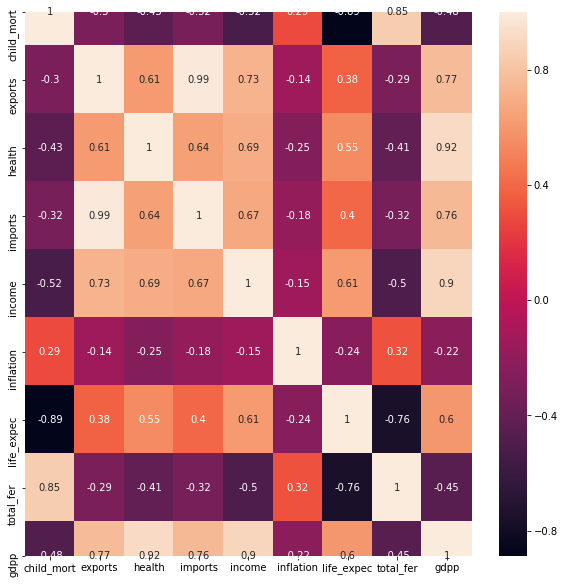

In [686]:
#Checking the correlation
plt.figure(figsize=(10,10))
sns.heatmap(countryData.corr(),annot=True)

Above heatmap gives below inferences:
1. There is a high correlation between import and export, i.e., 0.99
2. health and gdpp are highly correlated with correlation of 0.92
3. income and gdpp are highly correlated with correlation of 0.9
4. child_mortality and life_expentency are highly correlated with correlation of -0.89
5. child_mortality and total_fertility have a correlation of 0.85
6. life_expentency and total_fertility have a correlation of -0.76

# Exploratory Data Analysis

## Univariate Analysis

We are required to choose the countries that are in the direst need of aid. Therefore, we need to identify those countries which are using some socio-economic and health factors, that determine the overall development of the country.

We will look for lowest 10 countries for each factor.

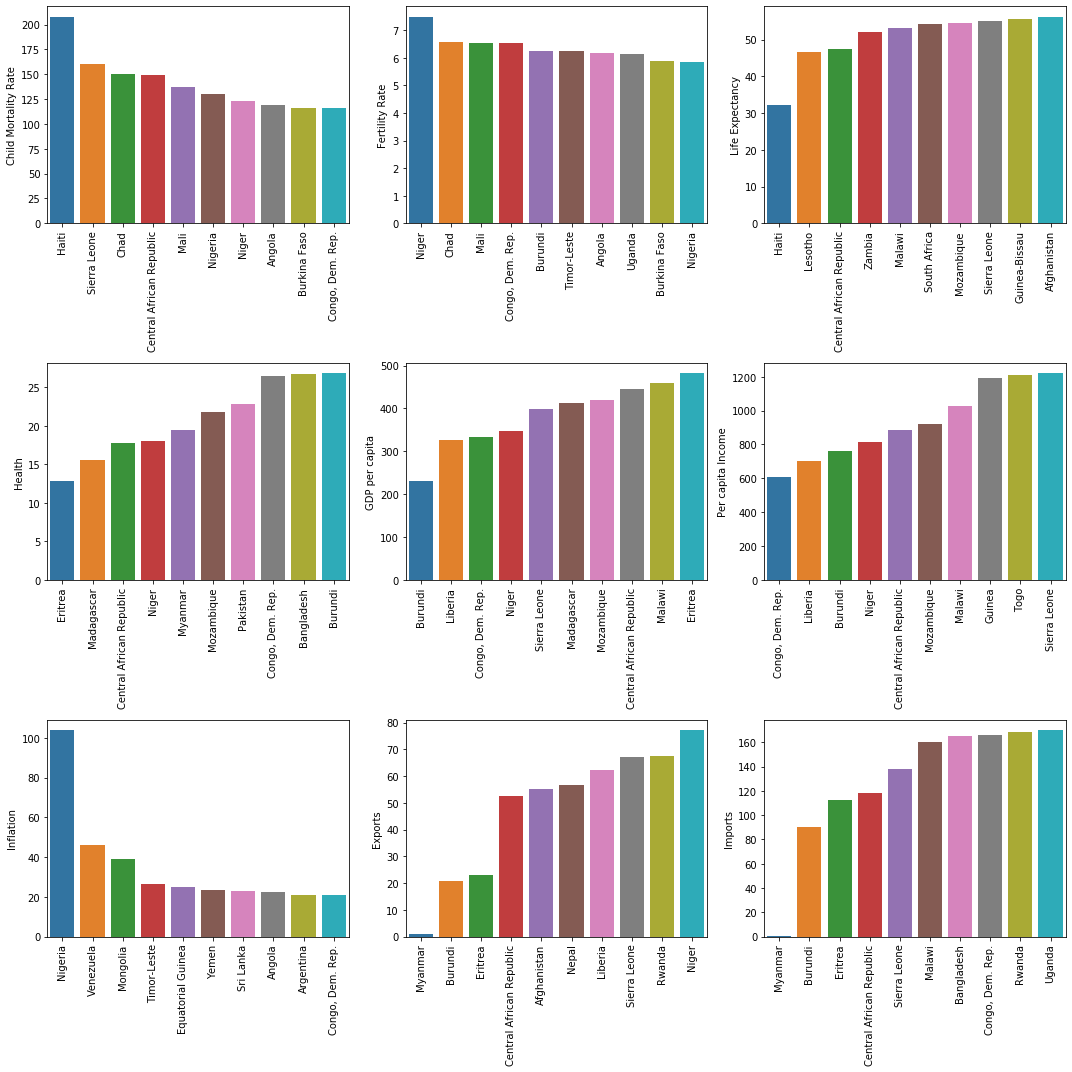

In [687]:
fig, axs = plt.subplots(3,3,figsize = (15,15))

top10_child_mort = countryData[['country','child_mort']].sort_values('child_mort', ascending = False).head(10)
plt1 = sns.barplot(x='country', y='child_mort', data= top10_child_mort, ax = axs[0,0])
plt1.set(xlabel = '', ylabel= 'Child Mortality Rate')

top10_total_fer = countryData[['country','total_fer']].sort_values('total_fer', ascending = False).head(10)
plt1 = sns.barplot(x='country', y='total_fer', data= top10_total_fer, ax = axs[0,1])
plt1.set(xlabel = '', ylabel= 'Fertility Rate')

bottom10_life_expec = countryData[['country','life_expec']].sort_values('life_expec', ascending = True).head(10)
plt1 = sns.barplot(x='country', y='life_expec', data= bottom10_life_expec, ax = axs[0,2])
plt1.set(xlabel = '', ylabel= 'Life Expectancy')

bottom10_health = countryData[['country','health']].sort_values('health', ascending = True).head(10)
plt1 = sns.barplot(x='country', y='health', data= bottom10_health, ax = axs[1,0])
plt1.set(xlabel = '', ylabel= 'Health')


bottom10_gdpp = countryData[['country','gdpp']].sort_values('gdpp', ascending = True).head(10)
plt1 = sns.barplot(x='country', y='gdpp', data= bottom10_gdpp, ax = axs[1,1])
plt1.set(xlabel = '', ylabel= 'GDP per capita')

bottom10_income = countryData[['country','income']].sort_values('income', ascending = True).head(10)
plt1 = sns.barplot(x='country', y='income', data= bottom10_income, ax = axs[1,2])
plt1.set(xlabel = '', ylabel= 'Per capita Income')


top10_inflation = countryData[['country','inflation']].sort_values('inflation', ascending = False).head(10)
plt1 = sns.barplot(x='country', y='inflation', data= top10_inflation, ax = axs[2,0])
plt1.set(xlabel = '', ylabel= 'Inflation')

bottom10_exports = countryData[['country','exports']].sort_values('exports', ascending = True).head(10)
plt1 = sns.barplot(x='country', y='exports', data= bottom10_exports, ax = axs[2,1])
plt1.set(xlabel = '', ylabel= 'Exports')

bottom10_imports = countryData[['country','imports']].sort_values('imports', ascending = True).head(10)
plt1 = sns.barplot(x='country', y='imports', data= bottom10_imports, ax = axs[2,2])
plt1.set(xlabel = '', ylabel= 'Imports')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation = 90)
    
plt.tight_layout()
plt.savefig('eda')
plt.show()

## Bivariate Analysis(Numerical-Numerical)

In [688]:
num_var=countryData[['child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp']]

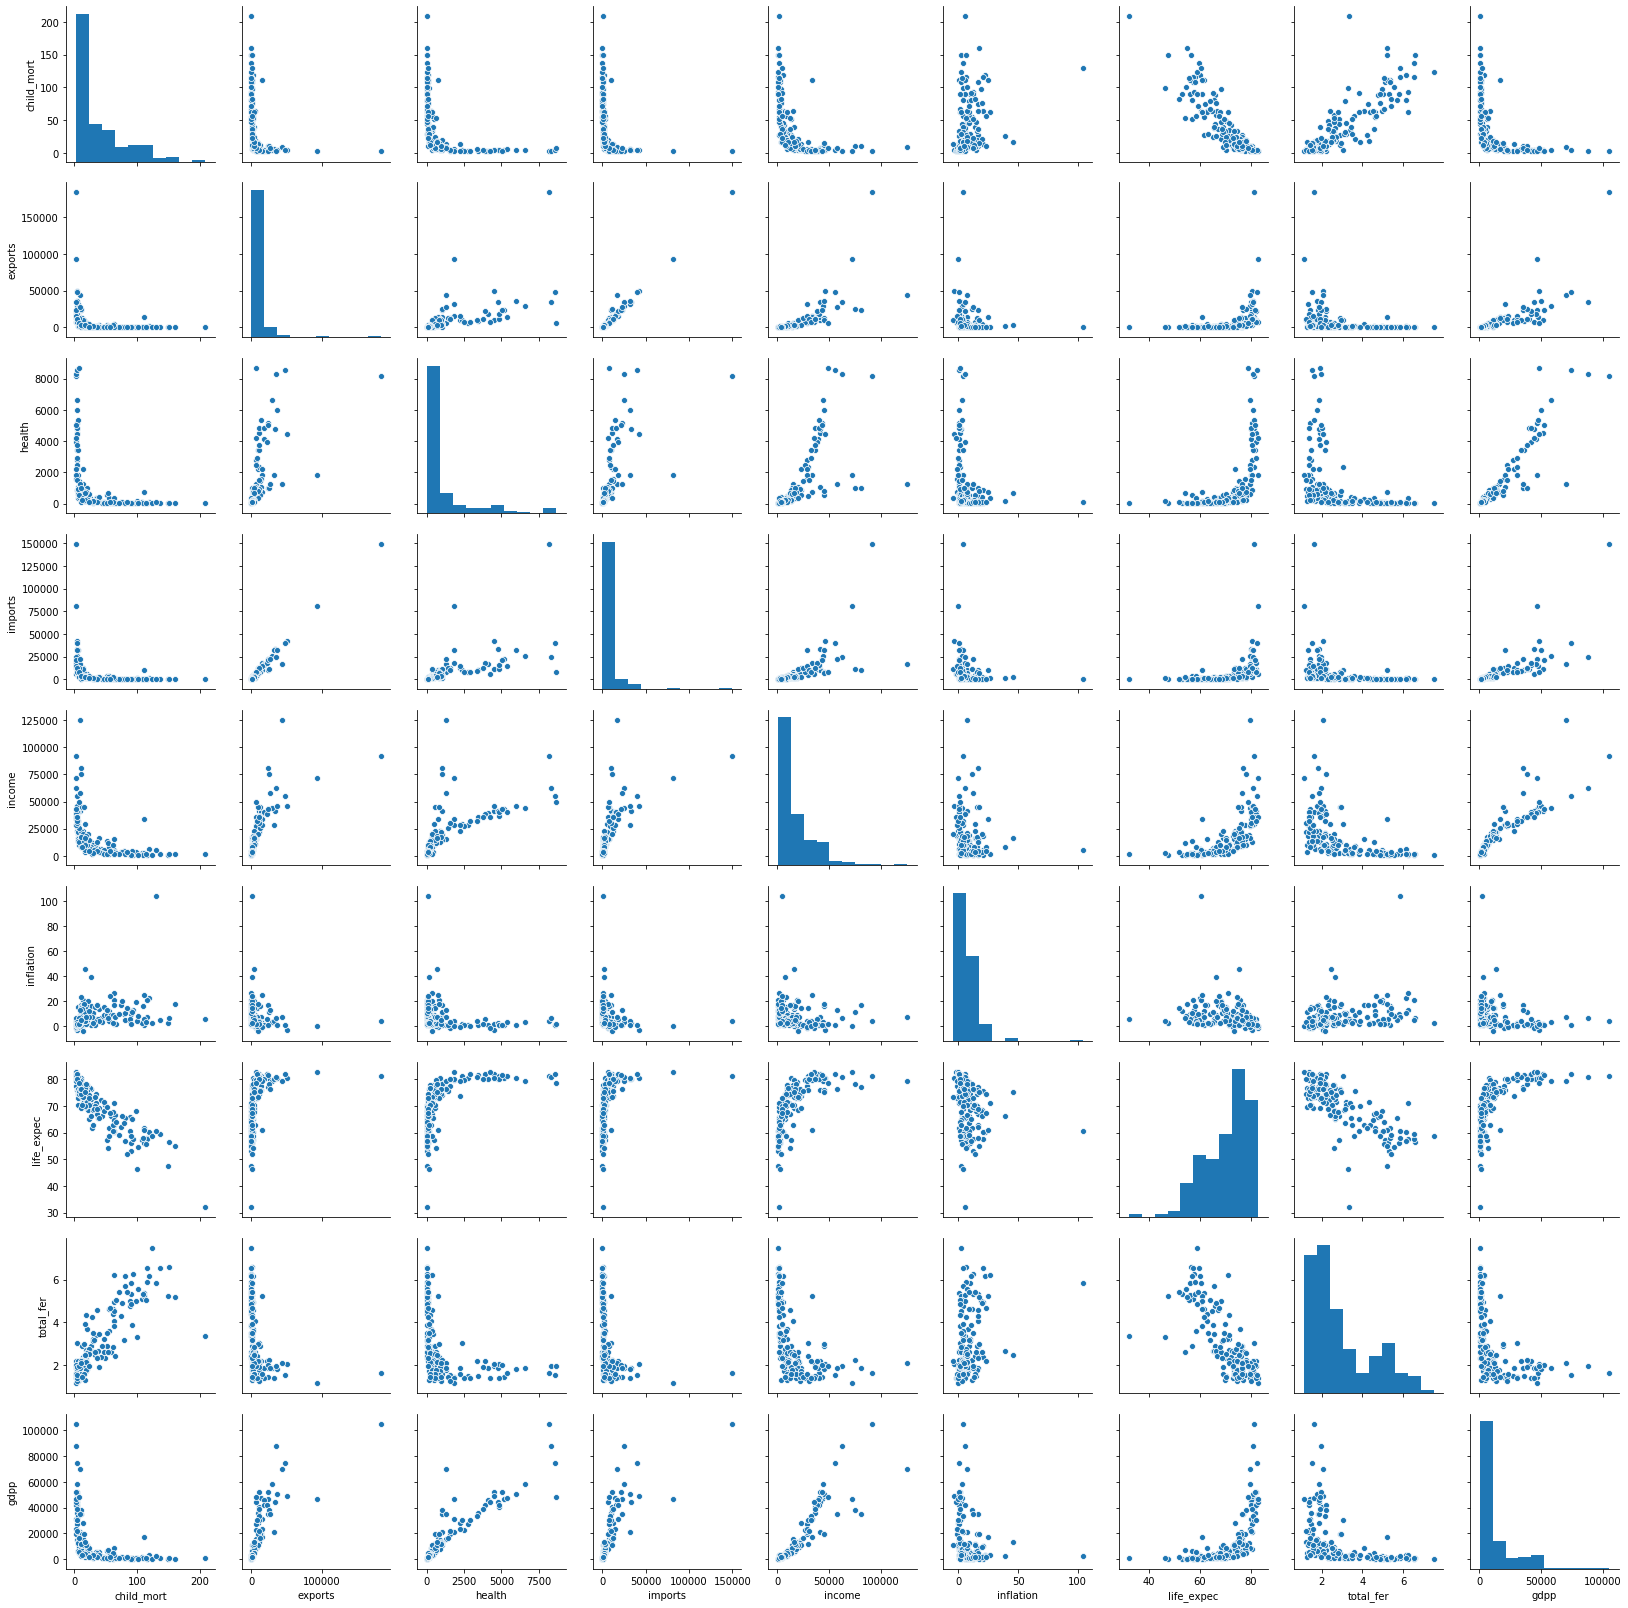

In [689]:
sns.pairplot(num_var)
plt.show()

## Data Preparation for Modelling

In [690]:
# Before manipulating data, we will save one copy of orignal data.
countryData1= countryData.copy()
countryData1.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [691]:
countryData.shape

(167, 10)

## Outlier Analysis

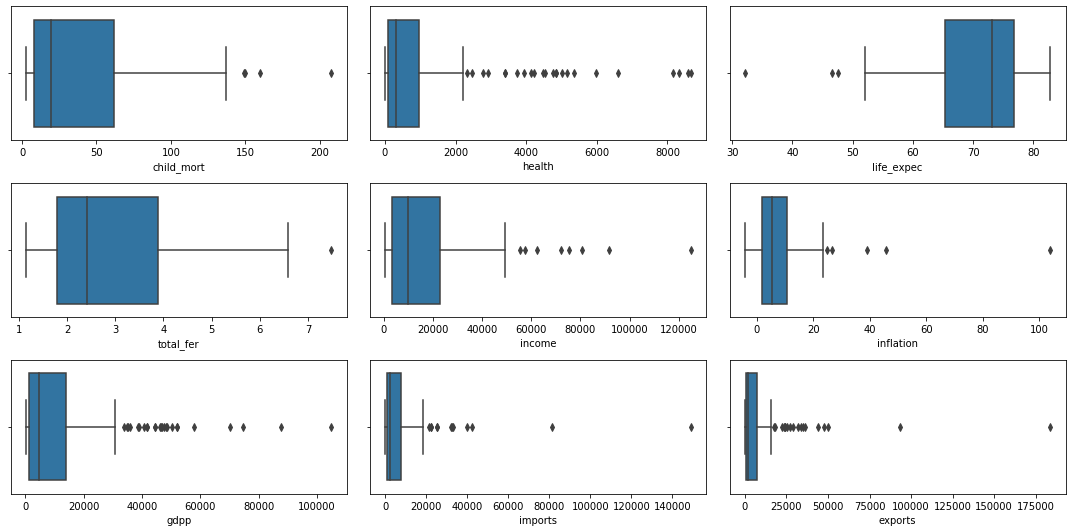

In [692]:
fig, axs = plt.subplots(3,3, figsize = (15,7.5))
plt1 = sns.boxplot(countryData1['child_mort'], ax = axs[0,0])
plt2 = sns.boxplot(countryData1['health'], ax = axs[0,1])
plt3 = sns.boxplot(countryData1['life_expec'], ax = axs[0,2])
plt4 = sns.boxplot(countryData1['total_fer'], ax = axs[1,0])
plt5 = sns.boxplot(countryData1['income'], ax = axs[1,1])
plt6 = sns.boxplot(countryData1['inflation'], ax = axs[1,2])
plt7 = sns.boxplot(countryData1['gdpp'], ax = axs[2,0])
plt8 = sns.boxplot(countryData1['imports'], ax = axs[2,1])
plt9 = sns.boxplot(countryData1['exports'], ax = axs[2,2])


plt.tight_layout()


In [693]:
countryData1.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,183750.000000,8663.600000,149100.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


### Outlier Treatment

#### As we can see there are a number of outliers in the data. We need to identify backward countries based on socio economic and health factors.
##### We will cap the outliers to values accordingly for analysis.

In [694]:
percentiles = countryData1['child_mort'].quantile([0.01,0.99]).values
countryData1['child_mort'][countryData1['child_mort'] <= percentiles[0]] = percentiles[0]
countryData1['child_mort'][countryData1['child_mort'] >= percentiles[1]] = percentiles[1]

percentiles = countryData1['health'].quantile([0.01,0.99]).values
countryData1['health'][countryData1['health'] <= percentiles[0]] = percentiles[0]
countryData1['health'][countryData1['health'] >= percentiles[1]] = percentiles[1]

percentiles = countryData1['life_expec'].quantile([0.01,0.99]).values
countryData1['life_expec'][countryData1['life_expec'] <= percentiles[0]] = percentiles[0]
countryData1['life_expec'][countryData1['life_expec'] >= percentiles[1]] = percentiles[1]

percentiles = countryData1['total_fer'].quantile([0.01,0.99]).values
countryData1['total_fer'][countryData1['total_fer'] <= percentiles[0]] = percentiles[0]
countryData1['total_fer'][countryData1['total_fer'] >= percentiles[1]] = percentiles[1]

percentiles = countryData1['income'].quantile([0.01,0.99]).values
countryData1['income'][countryData1['income'] <= percentiles[0]] = percentiles[0]
countryData1['income'][countryData1['income'] >= percentiles[1]] = percentiles[1]

percentiles = countryData1['inflation'].quantile([0.01,0.99]).values
countryData1['inflation'][countryData1['inflation'] <= percentiles[0]] = percentiles[0]
countryData1['inflation'][countryData1['inflation'] >= percentiles[1]] = percentiles[1]

percentiles = countryData1['gdpp'].quantile([0.01,0.99]).values
countryData1['gdpp'][countryData1['gdpp'] <= percentiles[0]] = percentiles[0]
countryData1['gdpp'][countryData1['gdpp'] >= percentiles[1]] = percentiles[1]

percentiles = countryData1['imports'].quantile([0.01,0.99]).values
countryData1['imports'][countryData1['imports'] <= percentiles[0]] = percentiles[0]
countryData1['imports'][countryData1['imports'] >= percentiles[1]] = percentiles[1]

percentiles = countryData1['exports'].quantile([0.01,0.99]).values
countryData1['exports'][countryData1['exports'] <= percentiles[0]] = percentiles[0]
countryData1['exports'][countryData1['exports'] >= percentiles[1]] = percentiles[1]

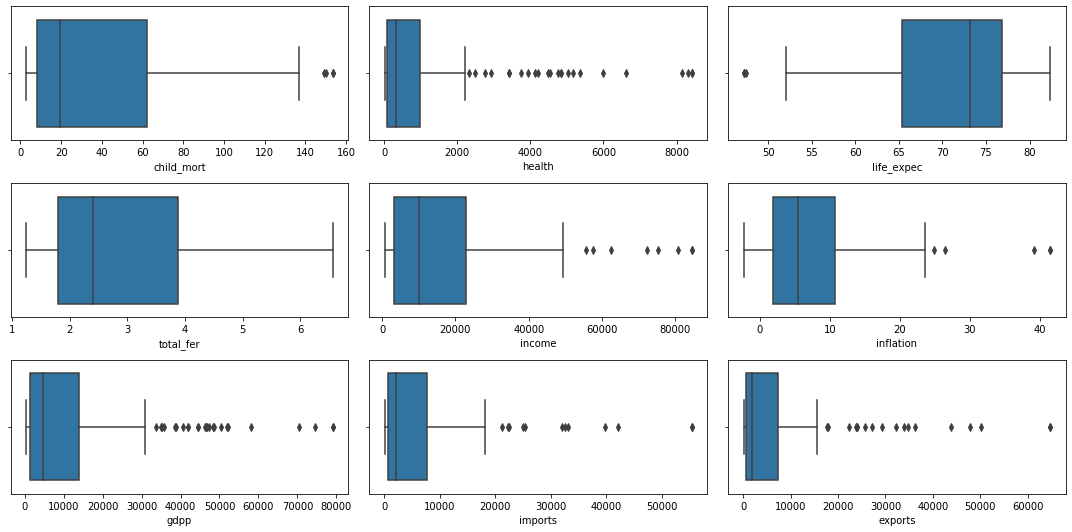

In [695]:
fig, axs = plt.subplots(3,3, figsize = (15,7.5))

plt1 = sns.boxplot(countryData1['child_mort'], ax = axs[0,0])
plt2 = sns.boxplot(countryData1['health'], ax = axs[0,1])
plt3 = sns.boxplot(countryData1['life_expec'], ax = axs[0,2])
plt4 = sns.boxplot(countryData1['total_fer'], ax = axs[1,0])
plt5 = sns.boxplot(countryData1['income'], ax = axs[1,1])
plt6 = sns.boxplot(countryData1['inflation'], ax = axs[1,2])
plt7 = sns.boxplot(countryData1['gdpp'], ax = axs[2,0])
plt8 = sns.boxplot(countryData1['imports'], ax = axs[2,1])
plt9 = sns.boxplot(countryData1['exports'], ax = axs[2,2])

plt.tight_layout()


In [696]:
countryData1.shape

(167, 10)

## Hopkins Check

The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [697]:
country_hop=countryData1[['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']]

In [698]:
# Calculating Hopkins score to know whether the data is good for clustering or not.
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
import pandas as pd
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [699]:
#First convert the numpy array that we have as a dataframe
country_hop.columns = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

In [700]:
country_hop.shape

(167, 9)

In [701]:
#Using the Hopkins Statistic function by passing the above dataframe as a paramter
hopkins(country_hop)

0.9519078202109791

Hopkins value is 0.95 which means that dataset has a tendency to cluster

# Scaling the Data

### Preparing the Data

In [702]:
rfm_df = countryData1[['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(167, 9)

In [703]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
rfm_df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.344012,-0.569638,-0.566983,-0.598844,-0.851772,0.263649,-1.693799,1.926928,-0.702314
1,-0.547543,-0.473873,-0.440417,-0.413679,-0.387025,-0.375251,0.663053,-0.865911,-0.498775
2,-0.272548,-0.424015,-0.486295,-0.476198,-0.221124,1.123260,0.686504,-0.035427,-0.477483
3,2.084186,-0.381264,-0.534113,-0.464070,-0.612136,1.936405,-1.236499,2.154642,-0.531000
4,-0.709457,-0.086754,-0.178431,0.139659,0.125202,-0.768917,0.721681,-0.544433,-0.032079


# Modelling

## Finding the Optimal number of Clusters

### Elbow-Curve/SSD to get the right no. of clusters
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

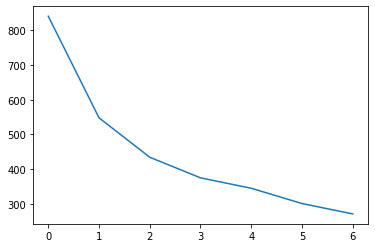

In [704]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7,  8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [705]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    

For n_clusters=2, the silhouette score is 0.46939980287788113
For n_clusters=3, the silhouette score is 0.40708993455880504
For n_clusters=4, the silhouette score is 0.39539142309551445
For n_clusters=5, the silhouette score is 0.3864288935632213
For n_clusters=6, the silhouette score is 0.30280954105276137
For n_clusters=7, the silhouette score is 0.3142190342453547
For n_clusters=8, the silhouette score is 0.2858078357857632


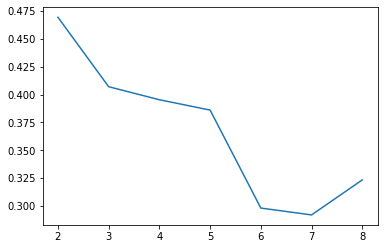

In [706]:
ss = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k).fit(rfm_df_scaled)
    ss.append([k, silhouette_score(rfm_df_scaled, kmeans.labels_)])
plt.plot(pd.DataFrame(ss)[0], pd.DataFrame(ss)[1]); 

In [707]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [708]:
kmeans.labels_

array([0, 2, 2, 0, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 0,
       2, 1, 2, 0, 0, 2, 0, 1, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 1, 2,
       1, 2, 2, 2, 2, 0, 0, 2, 2, 1, 1, 0, 0, 2, 1, 0, 2, 2, 2, 0, 0, 2,
       0, 2, 1, 2, 2, 2, 0, 1, 2, 1, 2, 1, 2, 2, 0, 0, 1, 2, 0, 2, 2, 0,
       0, 2, 2, 1, 2, 0, 0, 2, 2, 0, 1, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2,
       1, 1, 0, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 0, 2, 2,
       0, 1, 2, 1, 0, 0, 2, 1, 2, 2, 0, 2, 1, 1, 2, 0, 2, 0, 0, 2, 2, 2,
       2, 0, 2, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0])

In [709]:
# assigning the label to cluster_id column
countryData1['cluster_id'] = kmeans.labels_
countryData1.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,2
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,2
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,2


In [710]:
countryData1['cluster_id'].value_counts()

2    90
0    48
1    29
Name: cluster_id, dtype: int64

### From the business understanding we have learnt that Child Mortality, Income, GDPP are some important factors which decide the development of any country.  Hence, we will proceed with cluster profiling by using these 3 variables.
- gdpp: (The GDP per capita) Calculated as the Total GDP divided by the total population. 
- child_mort: Death of children under 5 years of age per 1000 live births.          
- income: Net income per person. 

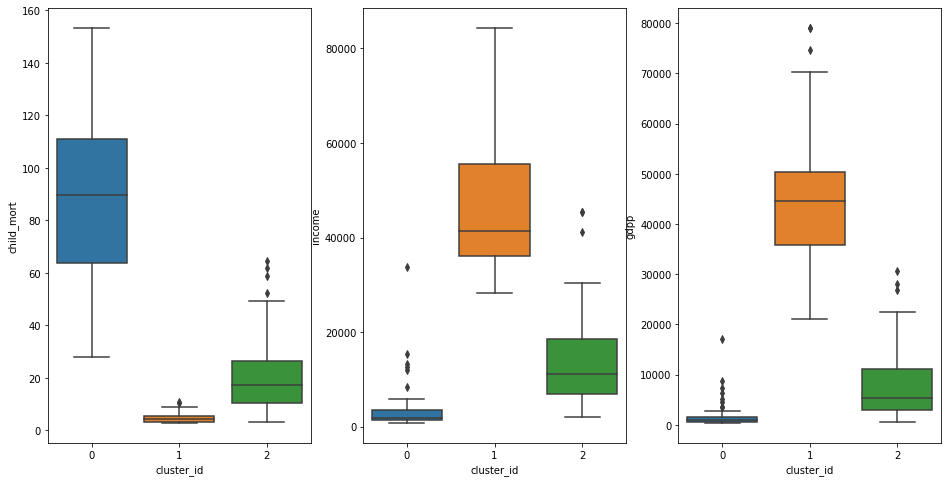

In [711]:
plt.figure(figsize=(16, 8))
plt.subplot(1,3,1)
sns.boxplot(x='cluster_id', y='child_mort', data=countryData1)
plt.subplot(1,3,2)
sns.boxplot(x='cluster_id', y='income', data=countryData1)
plt.subplot(1,3,3)
sns.boxplot(x='cluster_id', y='gdpp', data=countryData1)
plt.show()

#### Inferences:
Cluster 0 has lowest GDPP so we can say that the countries in cluster 0 must be in high Aid.
Cluster 0 has highest mortality rate so we can say that the countries in cluster 0 must be in high Aid.
Cluster 0 has lowest income so we can say that the countries in cluster 0 must be in high Aid.

#### Comparison between 'income','gdpp','child_mort'

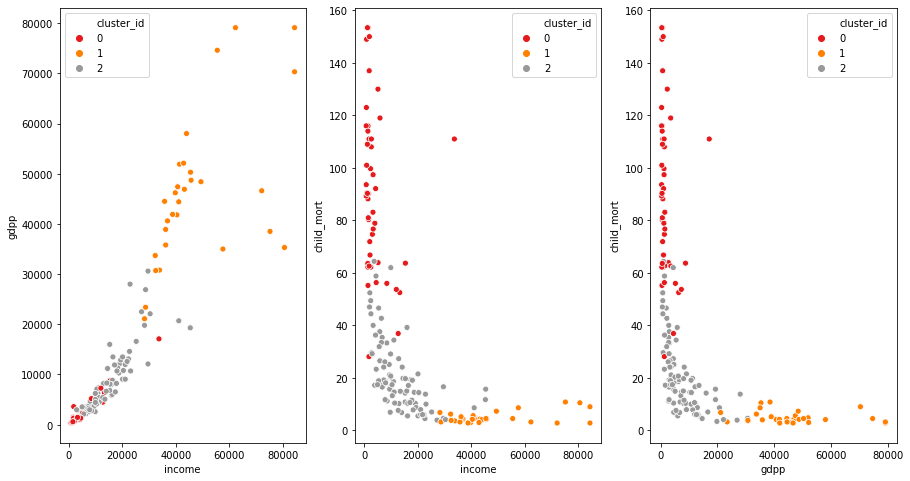

In [719]:
# plotting the cluster with respect to the clusters obtained
plt.figure(figsize=[15,8])
plt.subplot(1,3,1)
sns.scatterplot(x= 'income', y= 'gdpp', hue='cluster_id', legend='full', data=countryData1, palette= 'Set1')
plt.subplot(1,3,2)
sns.scatterplot(x= 'income', y= 'child_mort', hue='cluster_id', legend='full', data=countryData1, palette= 'Set1')
plt.subplot(1,3,3)
sns.scatterplot(x= 'gdpp', y= 'child_mort', hue='cluster_id', legend='full', data=countryData1, palette= 'Set1')
plt.show()

### Inferences:
Child Mortality is highest for Cluster 0 so, this cluster need some aid. Income and Gdpp are measures of development. Higher the per capita income and gdpp, better is the country's development. Income per capita and gdpp seem lowest for countries in clusters 0. Hence, these countries need some help.

## Cluster Profiling

In [713]:
countryData1.groupby('cluster_id').mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster_id,,,,,,,,,
0,90.335417,879.097657,114.939003,827.327888,3901.010000,10.608604,59.567083,4.972233,1911.400833
1,4.989655,25405.359310,4239.330028,21316.695862,47784.413793,2.906731,80.453103,1.757352,46068.137931
2,20.547778,3477.250726,528.894338,3589.291996,13804.333333,7.131624,73.393333,2.242591,7808.577778


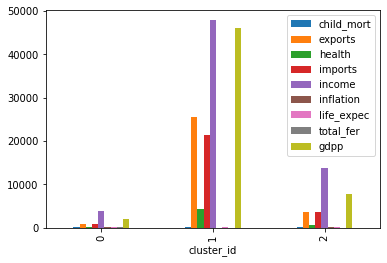

In [714]:
countryData1.groupby('cluster_id').mean().plot(kind= 'bar')
plt.show()

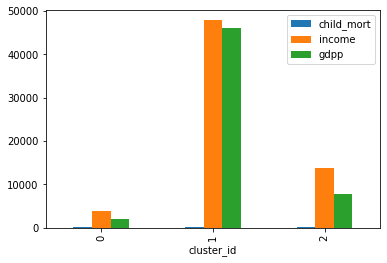

In [715]:
countryData1[['child_mort', 'income', 'gdpp', 'cluster_id']].groupby('cluster_id').mean().plot(kind= 'bar')
plt.show()

#### Inferences:
Child Mortality is highest for Cluster 0, These clusters need some aid.
Income and Gdpp are measures of development. Higher the per capita income and gdpp better is the country's development. Income per capita and gdpp seems lowest for countries in clusters 0. Hence, these countries need some help.

### Finding the observations that belong to certain cluster

In [716]:
# Filtering the data with selected cluster
df=countryData1[countryData1.cluster_id==0]
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.300,41.9174,248.297,1610.0,9.440,56.2,5.82,553.0,0
3,Angola,119.0,2199.190,100.6050,1514.370,5900.0,22.400,60.1,6.16,3530.0,0
17,Benin,111.0,180.404,31.0780,281.976,1820.0,0.885,61.8,5.36,758.0,0
21,Botswana,52.5,2768.600,527.0500,3257.550,13300.0,8.920,57.1,2.88,6350.0,0
25,Burkina Faso,116.0,110.400,38.7550,170.200,1430.0,6.810,57.9,5.87,575.0,0


In [717]:
d=df.sort_values(by=['income', 'gdpp', 'child_mort'], ascending=[True, True, False])
d.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
88,Liberia,89.3,62.457000,38.5860,302.80200,742.24,5.47,60.8,5.0200,331.62,0
37,"Congo, Dem. Rep.",116.0,137.274000,26.4194,165.66400,742.24,20.80,57.5,6.5400,334.00,0
26,Burundi,93.6,22.243716,26.7960,104.90964,764.00,12.30,57.7,6.2600,331.62,0
112,Niger,123.0,77.256000,17.9568,170.86800,814.00,2.55,58.8,6.5636,348.00,0
31,Central African Republic,149.0,52.628000,17.7508,118.19000,888.00,2.01,47.5,5.2100,446.00,0
106,Mozambique,101.0,131.985000,21.8299,193.57800,918.00,7.64,54.5,5.5600,419.00,0
94,Malawi,90.5,104.652000,30.2481,160.19100,1030.00,12.10,53.1,5.3100,459.00,0
63,Guinea,109.0,196.344000,31.9464,279.93600,1190.00,16.10,58.0,5.3400,648.00,0
150,Togo,90.3,196.176000,37.3320,279.62400,1210.00,1.18,58.7,4.8700,488.00,0
132,Sierra Leone,153.4,67.032000,52.2690,137.65500,1220.00,17.20,55.0,5.2000,399.00,0


In [718]:
d.shape

(48, 11)

## Hierarchical Clustering

In [660]:
rfm_df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.344012,-0.569638,-0.566983,-0.598844,-0.851772,0.263649,-1.693799,1.926928,-0.702314
1,-0.547543,-0.473873,-0.440417,-0.413679,-0.387025,-0.375251,0.663053,-0.865911,-0.498775
2,-0.272548,-0.424015,-0.486295,-0.476198,-0.221124,1.123260,0.686504,-0.035427,-0.477483
3,2.084186,-0.381264,-0.534113,-0.464070,-0.612136,1.936405,-1.236499,2.154642,-0.531000
4,-0.709457,-0.086754,-0.178431,0.139659,0.125202,-0.768917,0.721681,-0.544433,-0.032079


#### Single Linkage
Here, the distance between two clusters is defined as the shortest distance between two points in each cluster.

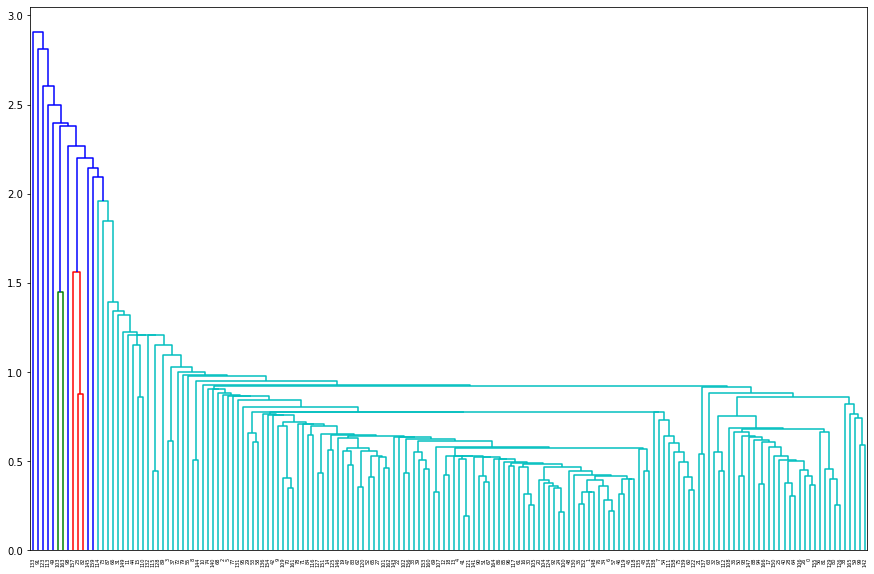

In [661]:
# single linkage
plt.figure(figsize=(15,10))
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

#### Complete Linkage
Here, the distance between two clusters is defined as the longest distance between two points in each cluster.

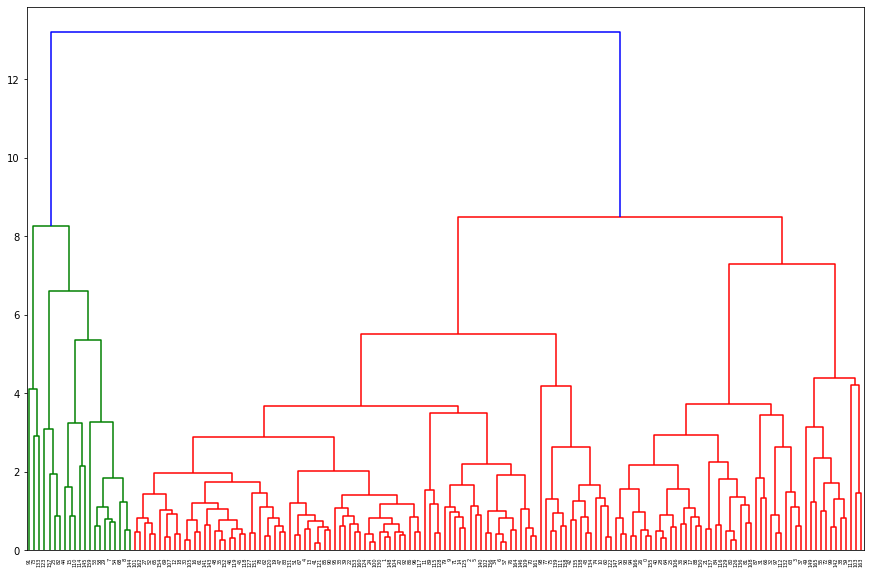

In [662]:
# complete linkage
plt.figure(figsize=(15,10))
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [663]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0,
       1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 2, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 0, 1, 1, 0,
       0, 1, 1, 2, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       2, 1, 0, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 2, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 2, 1, 2, 1, 1, 1, 0, 1, 0, 0])

In [664]:
# assign cluster labels
countryData1['cluster_labels'] = cluster_labels
countryData1.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,2,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,2,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0,1


In [665]:
countryData1['cluster_labels'].value_counts()

1    96
0    50
2    21
Name: cluster_labels, dtype: int64

##### This indicates that there is an improper distribution of countries in each cluster

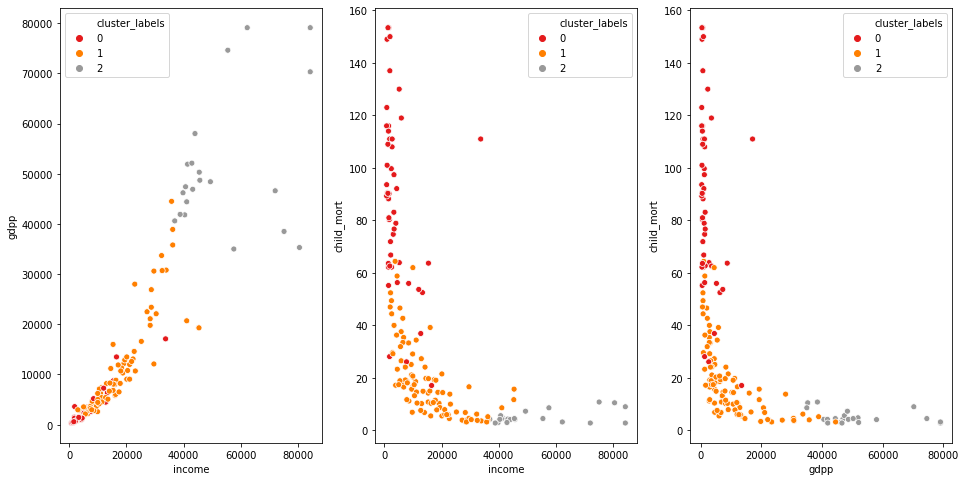

In [666]:
plt.figure(figsize=[16,8])
plt.subplot(1,3,1)
sns.scatterplot(x= 'income', y= 'gdpp', hue='cluster_labels', legend='full', data=countryData1, palette= 'Set1')
plt.subplot(1,3,2)
sns.scatterplot(x= 'income', y= 'child_mort', hue='cluster_labels', legend='full', data=countryData1, palette= 'Set1')
plt.subplot(1,3,3)
sns.scatterplot(x= 'gdpp', y= 'child_mort', hue='cluster_labels', legend='full', data=countryData1, palette= 'Set1')
plt.show()

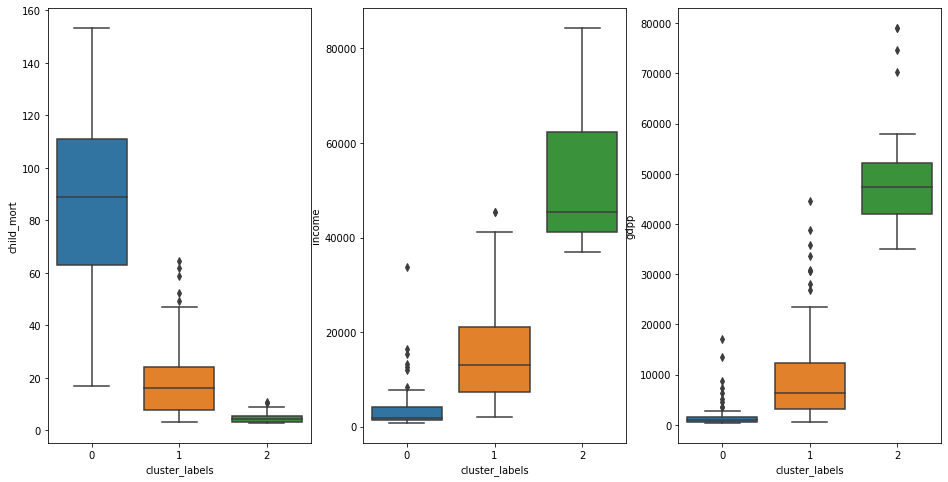

In [667]:
plt.figure(figsize=(16, 8))
plt.subplot(1,3,1)
sns.boxplot(x='cluster_labels', y='child_mort', data=countryData1)
plt.subplot(1,3,2)
sns.boxplot(x='cluster_labels', y='income', data=countryData1)
plt.subplot(1,3,3)
sns.boxplot(x='cluster_labels', y='gdpp', data=countryData1)
plt.show()

#### This implies below inferences:
1. Cluster 0 has highest rate of child mortality and lowest gdpp, so it is in highest need of aid
2. Cluster 2 has highest income and gdpp but lowest child mortality rate, so it has lowest need of id


## Cluster Profiling

In [668]:
countryData1.groupby('cluster_labels').mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
cluster_labels,,,,,,,,,,
0,87.586000,945.634750,126.481642,871.805773,4229.169600,11.797820,60.016400,4.875544,2157.944800,1.920000
1,19.188542,4326.711618,733.089171,4474.111767,15438.333333,5.936460,74.069479,2.181075,9849.187500,0.083333
2,5.176190,29964.696190,4731.309086,24182.246667,53421.333333,3.598248,80.298571,1.823962,51289.333333,1.000000


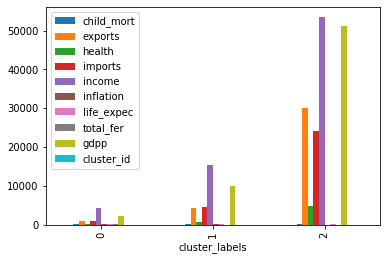

In [669]:
countryData1.groupby('cluster_labels').mean().plot(kind= 'bar')
plt.show()

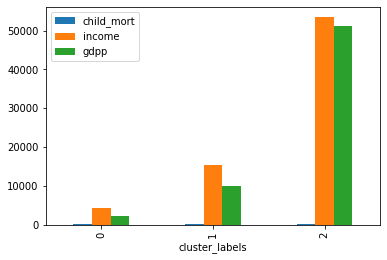

In [670]:
countryData1[['child_mort', 'income', 'gdpp', 'cluster_labels']].groupby('cluster_labels').mean().plot(kind= 'bar')
plt.show()

#### Above plots give below inferences :
1. Child Mortality is highest for Cluster 0, so it needs some aid. 
2. Income and Gdpp are measures of development. Higher the per capita income and gdpp better is the country's development. Income per capita and gdpp seems lowest for countries in cluster 0. Hence, these countries need some help.

### Finding the observations that belong to certain cluster

In [671]:
# let's filter the data with selected cluster
df1= countryData1[countryData1.cluster_labels==0]
df1.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
0,Afghanistan,90.2,55.300,41.9174,248.297,1610.0,9.440,56.2,5.82,553.0,2,0
3,Angola,119.0,2199.190,100.6050,1514.370,5900.0,22.400,60.1,6.16,3530.0,2,0
17,Benin,111.0,180.404,31.0780,281.976,1820.0,0.885,61.8,5.36,758.0,2,0
21,Botswana,52.5,2768.600,527.0500,3257.550,13300.0,8.920,57.1,2.88,6350.0,2,0
25,Burkina Faso,116.0,110.400,38.7550,170.200,1430.0,6.810,57.9,5.87,575.0,2,0


In [672]:
df1.shape

(50, 12)

## Final Analysis

##### It has been observed that clusters formed from both K-means and Hierarchial clustering and are not identical. 
##### In this solution K-means and Hierarchical don't produce identical insights. It would be perfectly fine if both provide identical insights in any other case
##### The clusters formed in K-means is better as compared to Hierarchial as it seems to be more precise. So, let's will proceed with the clusters formed by K-means 

##### To get the final list of Countries which should be focussed upon, resultant dataframe formed in K-means clustering is being used below.

In [720]:
###  List of countries which need help
d.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
88,Liberia,89.3,62.457000,38.5860,302.80200,742.24,5.47,60.8,5.0200,331.62,0
37,"Congo, Dem. Rep.",116.0,137.274000,26.4194,165.66400,742.24,20.80,57.5,6.5400,334.00,0
26,Burundi,93.6,22.243716,26.7960,104.90964,764.00,12.30,57.7,6.2600,331.62,0
112,Niger,123.0,77.256000,17.9568,170.86800,814.00,2.55,58.8,6.5636,348.00,0
31,Central African Republic,149.0,52.628000,17.7508,118.19000,888.00,2.01,47.5,5.2100,446.00,0


In [721]:
d.shape

(48, 11)

In [675]:
d.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.0
mean,20.547778,3477.250726,528.894338,3589.291996,13804.333333,7.131624,73.393333,2.242591,7808.577778,0.0
std,14.027503,3571.114959,550.816741,3263.686065,9246.444692,7.507506,3.995526,0.677176,6609.880152,0.0
min,3.400000,22.243716,19.463600,104.909640,1990.000000,-2.348800,63.000000,1.243200,592.000000,0.0
25%,10.325000,997.162500,178.038750,1339.535000,6870.000000,1.837500,70.400000,1.620000,3002.500000,0.0
50%,17.300000,1793.405000,354.536000,2348.640000,11150.000000,5.290000,74.050000,2.170000,5430.000000,0.0
75%,26.400000,5005.275000,706.597500,5064.575000,18600.000000,9.602500,76.300000,2.647500,11100.000000,0.0
max,64.400000,14386.500000,2770.700000,12914.800000,45400.000000,41.478000,81.400000,4.340000,30600.000000,0.0


In [728]:
#List of top 10 countries in cluster 0 which need aid
d.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
88,Liberia,89.3,62.457000,38.5860,302.80200,742.24,5.47,60.8,5.0200,331.62,0
37,"Congo, Dem. Rep.",116.0,137.274000,26.4194,165.66400,742.24,20.80,57.5,6.5400,334.00,0
26,Burundi,93.6,22.243716,26.7960,104.90964,764.00,12.30,57.7,6.2600,331.62,0
112,Niger,123.0,77.256000,17.9568,170.86800,814.00,2.55,58.8,6.5636,348.00,0
31,Central African Republic,149.0,52.628000,17.7508,118.19000,888.00,2.01,47.5,5.2100,446.00,0
106,Mozambique,101.0,131.985000,21.8299,193.57800,918.00,7.64,54.5,5.5600,419.00,0
94,Malawi,90.5,104.652000,30.2481,160.19100,1030.00,12.10,53.1,5.3100,459.00,0
63,Guinea,109.0,196.344000,31.9464,279.93600,1190.00,16.10,58.0,5.3400,648.00,0
150,Togo,90.3,196.176000,37.3320,279.62400,1210.00,1.18,58.7,4.8700,488.00,0
132,Sierra Leone,153.4,67.032000,52.2690,137.65500,1220.00,17.20,55.0,5.2000,399.00,0
